In [1]:
# importing the required modules

import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq, fftshift
from tqdm import tqdm

In [16]:
# info about the data
f = 3.3 # initial frequency
N_per_cycle = 100 # number of samples per cycle
freq_sampling =  4 * N_per_cycle * f # sampling frequency
noise_add = False
triggering = False
triggering_mode = 'falling' # rising or falling
N_sample = 8050 # number of samples
Total_time = N_sample / freq_sampling # total time
time_vary = False

dc_signal = 0.0 # dc signal

# manually setting the amplitude and phase/
amplitude = 0.001
phase = 0
tolerance = np.deg2rad(3)
print('Tolerance:', np.rad2deg(tolerance))
phis = []

t = np.linspace(0, Total_time, N_sample, endpoint=False) # time array

# creating a sin wave with the frequency array
y = amplitude * np.sin(2 * np.pi * f * t + phase) + dc_signal

# adding some noise to the signal
if noise_add:
    y = y + 0.001 * np.random.normal(size=t.size)

# creeating a squarae wave with the frequency array and a phase shift of 90 degrees
y_square = 0.05*np.sin(2 * np.pi * f * t)

# converting the signal to a square wave
y_square = 0.025 * np.sign(y_square) + 0.025

# adding some noise to the signal
if noise_add:
    y_square = y_square + 0.0009 * np.random.normal(size=t.size)

if time_vary:
    t_cycle = 1/f
    N_cycle = N_sample * (t_cycle / Total_time)
    rand_idx = np.random.randint(0, int(N_cycle))

    N_sample = N_sample - (2 * rand_idx)

    t = t[rand_idx: N_sample + rand_idx]
    y = y[rand_idx: N_sample + rand_idx]
    y_square = y_square[rand_idx: N_sample + rand_idx]



if triggering:
    # centralizing the reference signal
    y_square_max = np.max(y_square)
    y_square_min = np.min(y_square)
    y_square = y_square - ((y_square_max + y_square_min)/2)

    if triggering_mode == 'rising':
        first_rise_idx = 0
        for i in range(1, N_sample):
            if y_square[i] > 0 and y_square[i-1] < 0:
                first_rise_idx = i
                break
    if triggering_mode == 'falling':
        first_rise_idx = 0
        for i in range(1, N_sample):
            if y_square[i] < 0 and y_square[i-1] > 0:
                first_rise_idx = i
                break

    # triggered signal, reference signal and time
    triggered_sig = y[first_rise_idx:]
    triggered_ref = y_square[first_rise_idx:]
    triggered_time = t[first_rise_idx:] - t[first_rise_idx] # time starts from zero
else:
    triggered_sig = y
    triggered_ref = y_square
    triggered_time = t


# fft on the original reference signal
yf = fft(y_square)[1:]
xf = fftfreq(N_sample, 1 / freq_sampling)[1:]
freq = xf[np.argmax(np.abs(yf))]
# print('Frequency of the original square wave:', freq, 'Hz')

# creating sin and cos reference signals
ref_sin = 2 * np.sin(2 * np.pi * freq * triggered_time)
ref_cos = 2 * np.cos(2 * np.pi * freq * triggered_time)

# multiplying the triggered signal with the sin and cos reference signals
y_sin = triggered_sig * ref_sin
y_cos = triggered_sig * ref_cos

# taking the fft of the multiplied signals and finding the dc components
yf_sin = fft(y_sin)
yf_cos = fft(y_cos)

# finding the dc components
dc_sin = yf_sin[0].real / (len(ref_sin))
dc_cos = yf_cos[0].real / (len(ref_cos))

# finding voltage amplitude and phase
A = np.sqrt(dc_sin**2 + dc_cos**2)
phi = np.arctan2(dc_cos,dc_sin)
if phi < 0:
    phi = phi + 2 * np.pi

print('Amplitude:', A)
print('Phase:', np.degrees(phi))
print('Frequency:', freq)

print('\nOriginal Amplitude:', amplitude)
print('Original Phase:', np.degrees(phase))
print('Original Frequency:', f)
print('frequncy sampling:', freq_sampling)
print('Total time:', Total_time)
print('Number of samples:', N_sample)


Tolerance: 3.0000000000000004
Amplitude: 0.000972317469309101
Phase: 22.621702918700702
Frequency: 3.279503105590062

Original Amplitude: 0.001
Original Phase: 0.0
Original Frequency: 3.3
frequncy sampling: 1320.0
Total time: 6.098484848484849
Number of samples: 8050


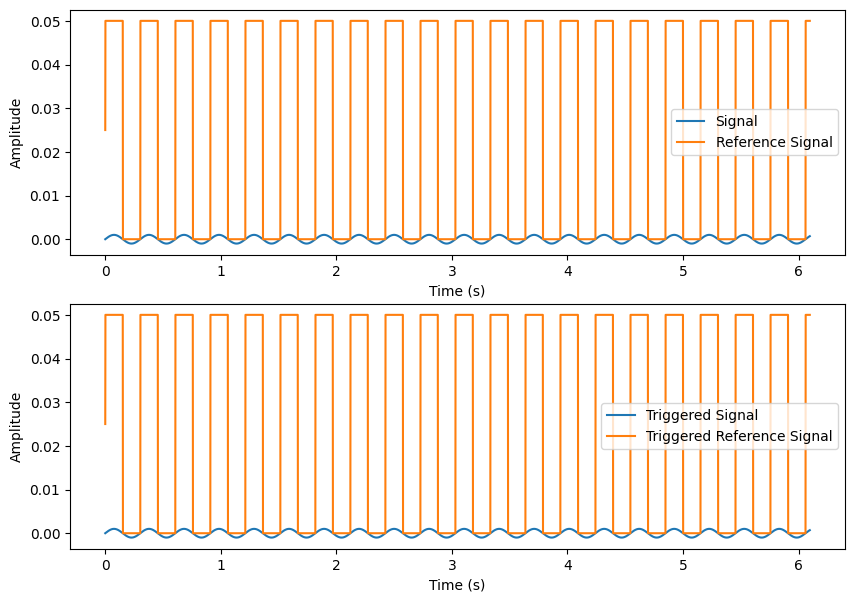

In [17]:
# plotting the signals
plt.figure(figsize=(10, 7))
plt.subplot(2, 1, 1)
plt.plot(t, y, label='Signal')
plt.plot(t, y_square, label='Reference Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(triggered_time, triggered_sig, label='Triggered Signal')
plt.plot(triggered_time, triggered_ref, label='Triggered Reference Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
